# Prueba Template Matching

Instalo Librerias Necesarias

In [ ]:
! pip install opencv-python

In [7]:
%pip install opencv-python-headless


  Obtaining dependency information for opencv-python-headless from https://files.pythonhosted.org/packages/1c/9b/583c8d9259f6fc19413f83fd18dd8e6cbc8eefb0b4dc6da52dd151fe3272/opencv_python_headless-4.10.0.84-cp37-abi3-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 MB 10.2 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


#### Primera prueba: Imagen Biferdil (se encuentra en la imagen con 20% de descuento)

In [9]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow # Import the alternative function

# Cargar las imágenes
producto = cv2.imread('/content/drive/MyDrive/9no Cuatrimestre/Proyecto Final/Proyecto Final - Grupo 2/Pruebas Template Matching /Captura de Pantalla 2024-08-19 a la(s) 21.18.25.png', cv2.IMREAD_COLOR)
#producto = cv2.imread('/content/drive/MyDrive/9no Cuatrimestre/Proyecto Final/Proyecto Final - Grupo 2/Pruebas Template Matching /descuento_20.png', cv2.IMREAD_COLOR)
gondola = cv2.imread('/content/drive/MyDrive/9no Cuatrimestre/Proyecto Final/Proyecto Final - Grupo 2/Pruebas Template Matching /WhatsApp Image 2024-08-12 at 14.11.10 (3).jpeg', cv2.IMREAD_COLOR)

# Convertir imágenes a escala de grises
producto_gray = cv2.cvtColor(producto, cv2.COLOR_BGR2GRAY)
gondola_gray = cv2.cvtColor(gondola, cv2.COLOR_BGR2GRAY)

# Crear el detector SIFT
sift = cv2.SIFT_create()

# Detectar keypoints y computar descriptores
kp1, des1 = sift.detectAndCompute(producto_gray, None)
kp2, des2 = sift.detectAndCompute(gondola_gray, None)

# Crear el objeto FLANN (Fast Library for Approximate Nearest Neighbors)
index_params = dict(algorithm=1, trees=5)
search_params = dict(checks=50)   # El número de veces que el árbol es revisado
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Realizar el matching de descriptores usando KNN (k-nearest neighbors)
matches = flann.knnMatch(des1, des2, k=2)

# Aplicar ratio test de David Lowe
good_matches = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good_matches.append(m)

# Si se encuentran suficientes "good matches", intentar localizar el producto
if len(good_matches) > 10:
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # Estimar homografía
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    matches_mask = mask.ravel().tolist()

    # Obtener dimensiones del producto
    h, w = producto_gray.shape

    # Definir puntos del producto
    pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)

    # Transformar puntos según la homografía encontrada
    dst = cv2.perspectiveTransform(pts, M)

    # Dibujar líneas alrededor del producto detectado
    gondola = cv2.polylines(gondola, [np.int32(dst)], True, (0, 255, 0), 3, cv2.LINE_AA)

# Dibujar y mostrar las coincidencias
resultado = cv2.drawMatches(producto, kp1, gondola, kp2, good_matches, None, matchesMask=matches_mask, flags=2)

# Replace cv2.imshow() with cv2_imshow()
cv2_imshow(resultado)
cv2.waitKey(0)
cv2.destroyAllWindows()

ModuleNotFoundError: No module named 'google'

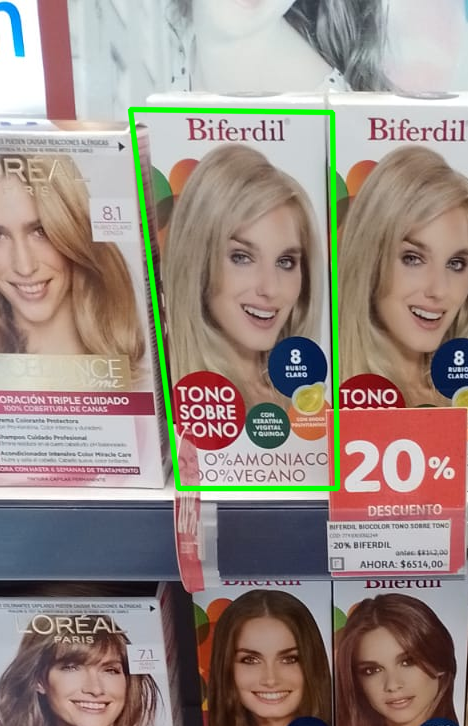

In [28]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Función para recortar la región alrededor del producto con un margen adicional
def crop_expanded_region(gondola, dst, margin_factor=2):
    # Obtener los puntos de la región del producto
    rect = cv2.boundingRect(dst)
    x, y, w, h = rect

    # Calcular el margen adicional
    margin_x = int(w * (margin_factor - 1) / 2)
    margin_y = int(h * (margin_factor - 1) / 2)

    # Ajustar los límites del recorte con el margen
    x1 = max(x - margin_x, 0)
    y1 = max(y - margin_y, 0)
    x2 = min(x + w + margin_x, gondola.shape[1])
    y2 = min(y + h + margin_y, gondola.shape[0])

    # Recortar la región de la imagen de la góndola
    cropped_gondola = gondola[y1:y2, x1:x2]
    return cropped_gondola

# Ajustar el margen de recorte
cropped_gondola_expanded = crop_expanded_region(gondola, dst, margin_factor=2.25)
cv2_imshow(cropped_gondola_expanded)
cv2.waitKey(0)
cv2.destroyAllWindows()


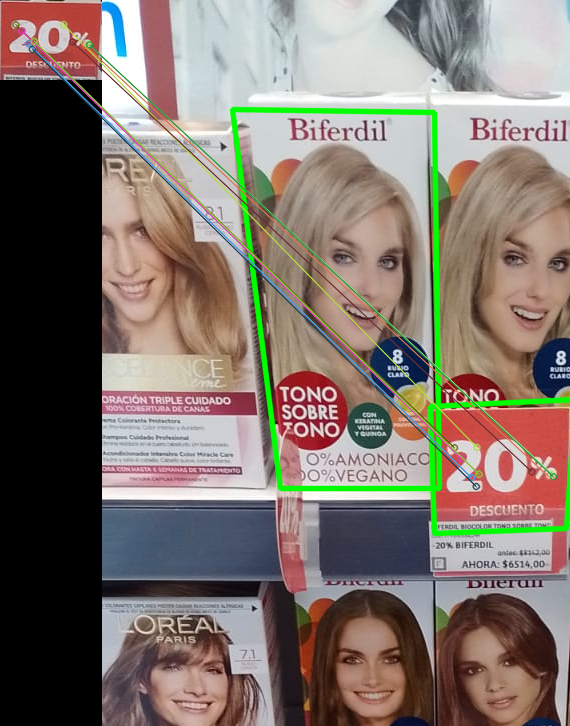

In [30]:
# Cargar la imagen del cartel de promoción
#producto = cv2.imread('/content/drive/MyDrive/9no Cuatrimestre/Proyecto Final/Proyecto Final - Grupo 2/Pruebas Template Matching /descuento_20.png', cv2.IMREAD_COLOR)

cartel = cv2.imread('/content/drive/MyDrive/9no Cuatrimestre/Proyecto Final/Proyecto Final - Grupo 2/Pruebas Template Matching /descuento_20.png', cv2.IMREAD_COLOR)
cartel_gray = cv2.cvtColor(cartel, cv2.COLOR_BGR2GRAY)

# Convertir la región recortada a escala de grises
cropped_gondola_gray = cv2.cvtColor(cropped_gondola_expanded, cv2.COLOR_BGR2GRAY)

# Crear el detector SIFT
sift = cv2.SIFT_create()

# Detectar keypoints y descriptores para el cartel
kp_cartel, des_cartel = sift.detectAndCompute(cartel_gray, None)

# Detectar keypoints y descriptores para la región recortada
kp_cropped, des_cropped = sift.detectAndCompute(cropped_gondola_gray, None)

# Crear el objeto FLANN
index_params = dict(algorithm=1, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Realizar el matching de descriptores
matches = flann.knnMatch(des_cartel, des_cropped, k=2)

# Aplicar ratio test de David Lowe
good_matches = []
for m, n in matches:
    if m.distance < 0.6 * n.distance:
        good_matches.append(m)

# Si se encuentran suficientes "good matches", intentar localizar el cartel
if len(good_matches) > 10:
    src_pts = np.float32([kp_cartel[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp_cropped[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # Estimar homografía
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    matches_mask = mask.ravel().tolist()

    # Obtener dimensiones del cartel
    h, w = cartel_gray.shape

    # Definir puntos del cartel
    pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)

    # Transformar puntos según la homografía encontrada
    dst = cv2.perspectiveTransform(pts, M)

    # Dibujar líneas alrededor del cartel detectado
    cropped_gondola_expanded = cv2.polylines(cropped_gondola_expanded, [np.int32(dst)], True, (0, 255, 0), 3, cv2.LINE_AA)

# Dibujar y mostrar las coincidencias
matches_mask = [1] * len(good_matches)
resultado_cartel = cv2.drawMatches(cartel, kp_cartel, cropped_gondola_expanded, kp_cropped, good_matches, None, matchesMask=matches_mask, flags=2)

cv2_imshow(resultado_cartel)
cv2.waitKey(0)
cv2.destroyAllWindows()


#### Segunda Prueba: Imagen Shampoo (no se encuentra en la imagen)


No se encontró una coincidencia suficientemente buena.


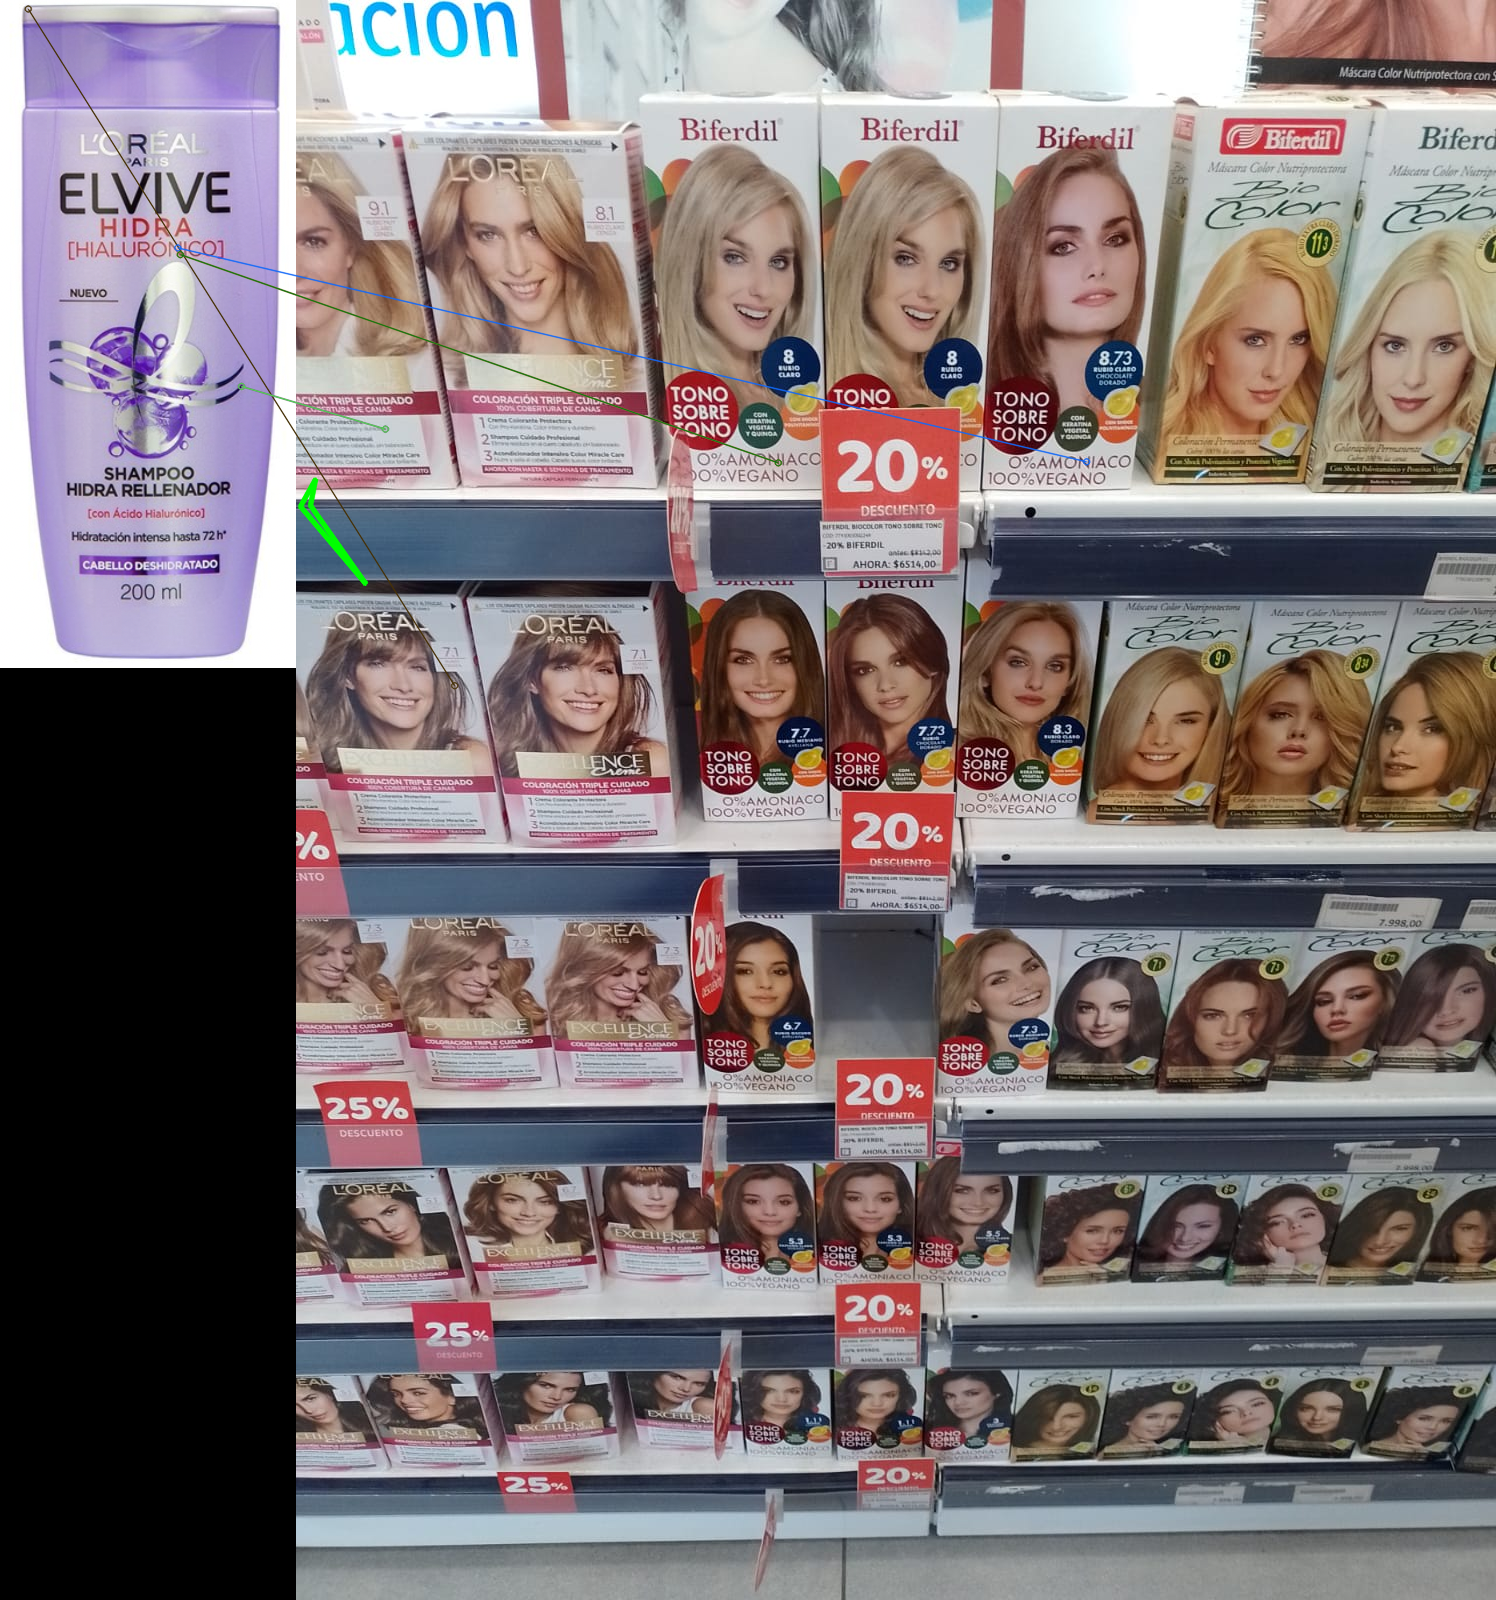

In [42]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Cargar las imágenes
producto = cv2.imread('/content/drive/MyDrive/9no Cuatrimestre/Proyecto Final/Proyecto Final - Grupo 2/Pruebas Template Matching /shampoo_elvive_violeta.png', cv2.IMREAD_COLOR)

gondola = cv2.imread('/content/drive/MyDrive/9no Cuatrimestre/Proyecto Final/Proyecto Final - Grupo 2/Pruebas Template Matching /WhatsApp Image 2024-08-12 at 14.11.10 (3).jpeg', cv2.IMREAD_COLOR)

# Convertir imágenes a escala de grises
producto_gray = cv2.cvtColor(producto, cv2.COLOR_BGR2GRAY)
gondola_gray = cv2.cvtColor(gondola, cv2.COLOR_BGR2GRAY)

# Crear el detector SIFT
sift = cv2.SIFT_create()

# Detectar keypoints y computar descriptores
kp1, des1 = sift.detectAndCompute(producto_gray, None)
kp2, des2 = sift.detectAndCompute(gondola_gray, None)

# Crear el objeto FLANN (Fast Library for Approximate Nearest Neighbors)
index_params = dict(algorithm=1, trees=5)
search_params = dict(checks=50)   # El número de veces que el árbol es revisado
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Realizar el matching de descriptores usando KNN (k-nearest neighbors)
matches = flann.knnMatch(des1, des2, k=2)

# Aplicar ratio test de David Lowe
good_matches = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good_matches.append(m)

# Definir un umbral para considerar una buena coincidencia
umbral_buenas_coincidencias = 20

# Si se encuentran suficientes "good matches", intentar localizar el producto
if len(good_matches) > umbral_buenas_coincidencias:
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # Estimar homografía
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    matches_mask = mask.ravel().tolist()

    # Obtener dimensiones del producto
    h, w = producto_gray.shape

    # Definir puntos del producto
    pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)

    # Transformar puntos según la homografía encontrada
    dst = cv2.perspectiveTransform(pts, M)

    # Dibujar líneas alrededor del producto detectado
    gondola = cv2.polylines(gondola, [np.int32(dst)], True, (0, 255, 0), 3, cv2.LINE_AA)

    # Dibujar y mostrar las coincidencias
    resultado = cv2.drawMatches(producto, kp1, gondola, kp2, good_matches, None, matchesMask=matches_mask, flags=2)
    cv2_imshow(resultado)
else:
    print("No se encontró una coincidencia suficientemente buena.")
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # Estimar homografía
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    matches_mask = mask.ravel().tolist()

    # Obtener dimensiones del producto
    h, w = producto_gray.shape

    # Definir puntos del producto
    pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)

    # Transformar puntos según la homografía encontrada
    dst = cv2.perspectiveTransform(pts, M)

    # Dibujar líneas alrededor del producto detectado
    gondola = cv2.polylines(gondola, [np.int32(dst)], True, (0, 255, 0), 3, cv2.LINE_AA)

    # Dibujar y mostrar las coincidencias
    resultado = cv2.drawMatches(producto, kp1, gondola, kp2, good_matches, None, matchesMask=matches_mask, flags=2)
    cv2_imshow(resultado)

cv2.waitKey(0)
cv2.destroyAllWindows()


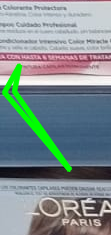

In [43]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Función para recortar la región alrededor del producto con un margen adicional
def crop_expanded_region(gondola, dst, margin_factor=2):
    # Obtener los puntos de la región del producto
    rect = cv2.boundingRect(dst)
    x, y, w, h = rect

    # Calcular el margen adicional
    margin_x = int(w * (margin_factor - 1) / 2)
    margin_y = int(h * (margin_factor - 1) / 2)

    # Ajustar los límites del recorte con el margen
    x1 = max(x - margin_x, 0)
    y1 = max(y - margin_y, 0)
    x2 = min(x + w + margin_x, gondola.shape[1])
    y2 = min(y + h + margin_y, gondola.shape[0])

    # Recortar la región de la imagen de la góndola
    cropped_gondola = gondola[y1:y2, x1:x2]
    return cropped_gondola

# Ajustar el margen de recorte
cropped_gondola_expanded = crop_expanded_region(gondola, dst, margin_factor=2.25)
cv2_imshow(cropped_gondola_expanded)
cv2.waitKey(0)
cv2.destroyAllWindows()


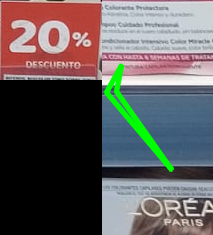

In [44]:
# Cargar la imagen del cartel de promoción
#producto = cv2.imread('/content/drive/MyDrive/9no Cuatrimestre/Proyecto Final/Proyecto Final - Grupo 2/Pruebas Template Matching /descuento_20.png', cv2.IMREAD_COLOR)

cartel = cv2.imread('/content/drive/MyDrive/9no Cuatrimestre/Proyecto Final/Proyecto Final - Grupo 2/Pruebas Template Matching /descuento_20.png', cv2.IMREAD_COLOR)
cartel_gray = cv2.cvtColor(cartel, cv2.COLOR_BGR2GRAY)

# Convertir la región recortada a escala de grises
cropped_gondola_gray = cv2.cvtColor(cropped_gondola_expanded, cv2.COLOR_BGR2GRAY)

# Crear el detector SIFT
sift = cv2.SIFT_create()

# Detectar keypoints y descriptores para el cartel
kp_cartel, des_cartel = sift.detectAndCompute(cartel_gray, None)

# Detectar keypoints y descriptores para la región recortada
kp_cropped, des_cropped = sift.detectAndCompute(cropped_gondola_gray, None)

# Crear el objeto FLANN
index_params = dict(algorithm=1, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Realizar el matching de descriptores
matches = flann.knnMatch(des_cartel, des_cropped, k=2)

# Aplicar ratio test de David Lowe
good_matches = []
for m, n in matches:
    if m.distance < 0.6 * n.distance:
        good_matches.append(m)

# Si se encuentran suficientes "good matches", intentar localizar el cartel
if len(good_matches) > 10:
    src_pts = np.float32([kp_cartel[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp_cropped[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # Estimar homografía
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    matches_mask = mask.ravel().tolist()

    # Obtener dimensiones del cartel
    h, w = cartel_gray.shape

    # Definir puntos del cartel
    pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)

    # Transformar puntos según la homografía encontrada
    dst = cv2.perspectiveTransform(pts, M)

    # Dibujar líneas alrededor del cartel detectado
    cropped_gondola_expanded = cv2.polylines(cropped_gondola_expanded, [np.int32(dst)], True, (0, 255, 0), 3, cv2.LINE_AA)

# Dibujar y mostrar las coincidencias
matches_mask = [1] * len(good_matches)
resultado_cartel = cv2.drawMatches(cartel, kp_cartel, cropped_gondola_expanded, kp_cropped, good_matches, None, matchesMask=matches_mask, flags=2)

cv2_imshow(resultado_cartel)
cv2.waitKey(0)
cv2.destroyAllWindows()


#### Tercer Prueba: Imagen Biferdil Biocolor (se encuentra en la imagen, no tiene desc)


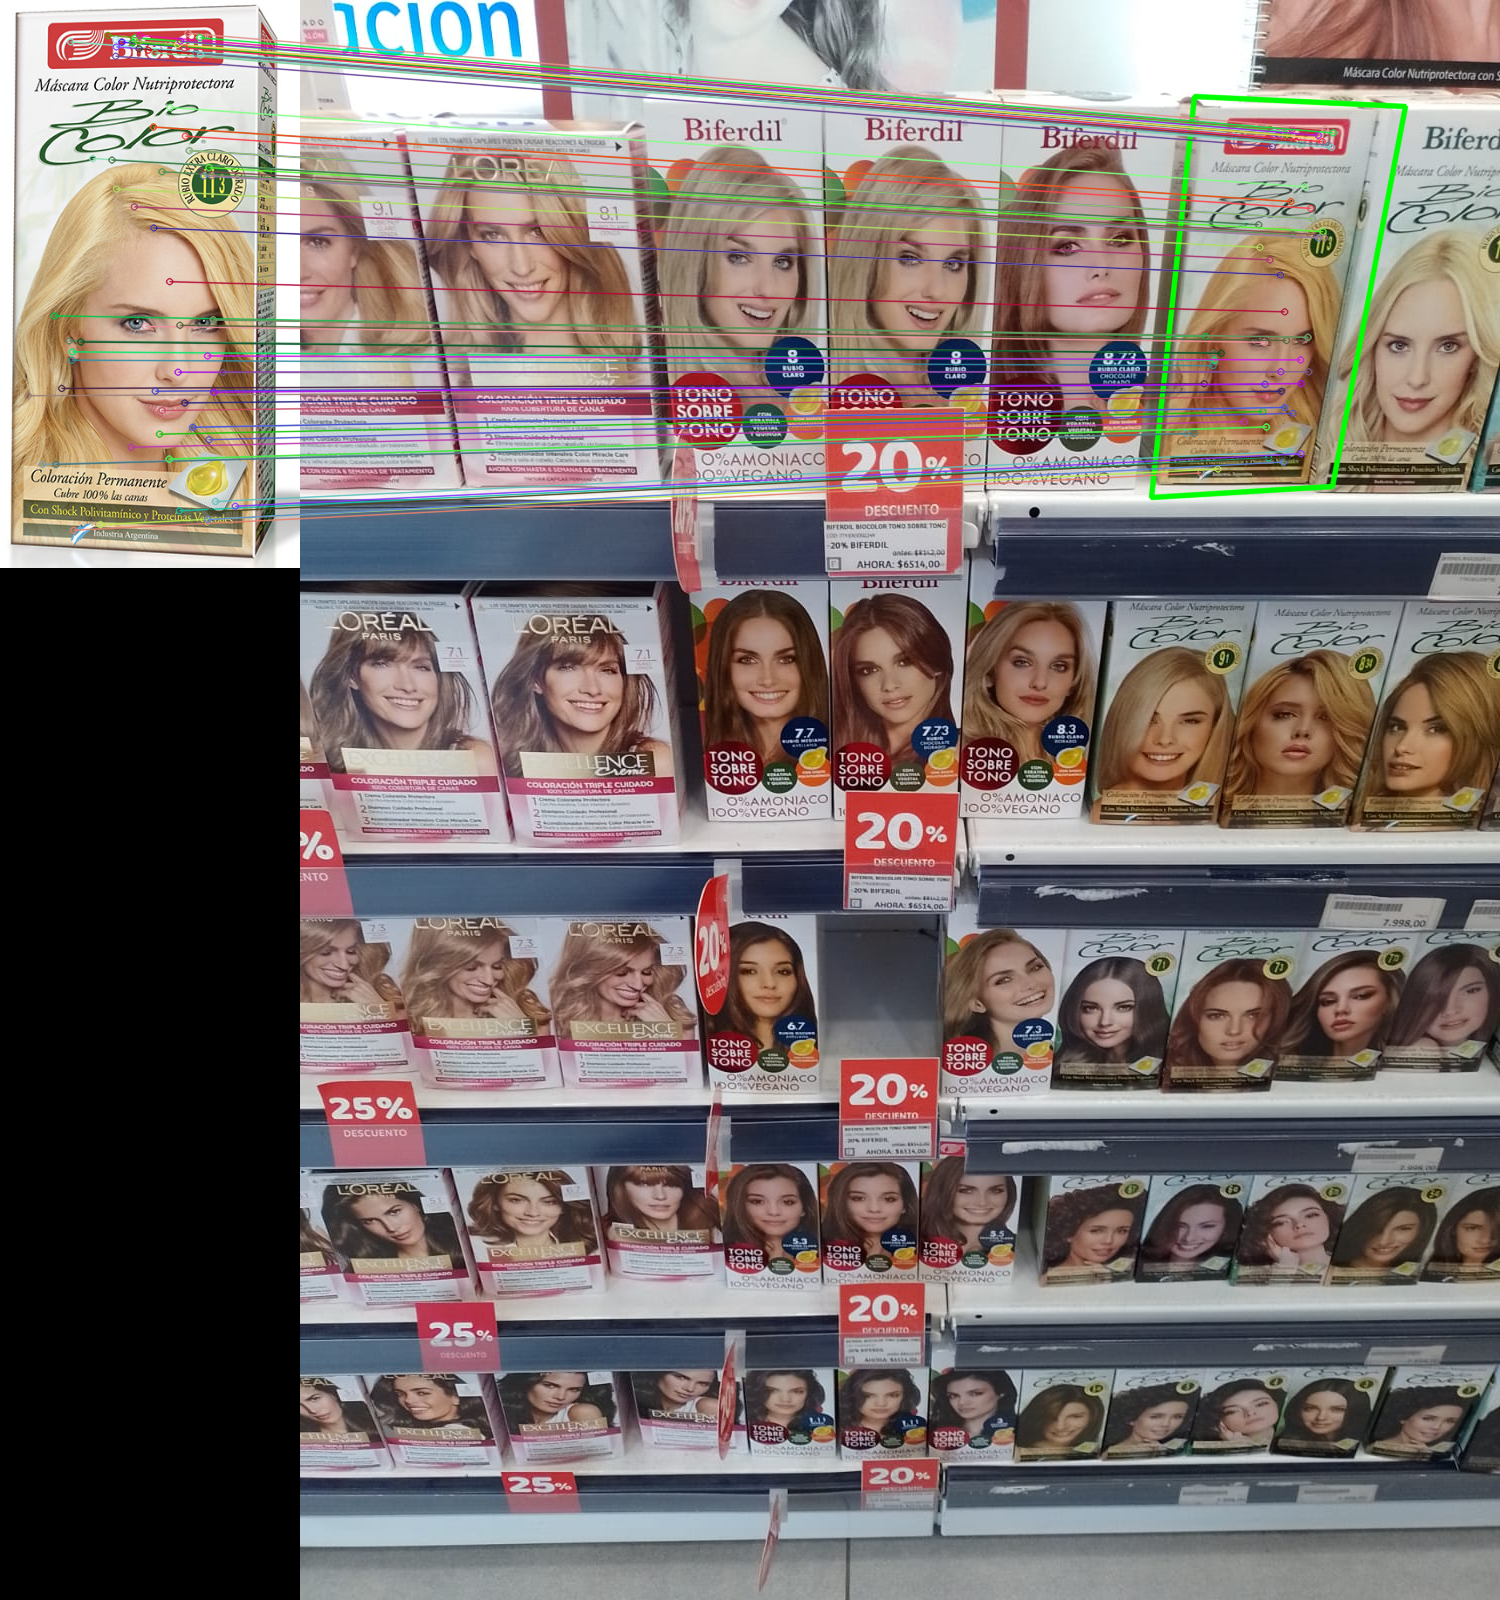

In [45]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Cargar las imágenes
producto = cv2.imread('/content/drive/MyDrive/9no Cuatrimestre/Proyecto Final/Proyecto Final - Grupo 2/Pruebas Template Matching /Biferdil_Biocolor.png', cv2.IMREAD_COLOR)

gondola = cv2.imread('/content/drive/MyDrive/9no Cuatrimestre/Proyecto Final/Proyecto Final - Grupo 2/Pruebas Template Matching /WhatsApp Image 2024-08-12 at 14.11.10 (3).jpeg', cv2.IMREAD_COLOR)

# Convertir imágenes a escala de grises
producto_gray = cv2.cvtColor(producto, cv2.COLOR_BGR2GRAY)
gondola_gray = cv2.cvtColor(gondola, cv2.COLOR_BGR2GRAY)

# Crear el detector SIFT
sift = cv2.SIFT_create()

# Detectar keypoints y computar descriptores
kp1, des1 = sift.detectAndCompute(producto_gray, None)
kp2, des2 = sift.detectAndCompute(gondola_gray, None)

# Crear el objeto FLANN (Fast Library for Approximate Nearest Neighbors)
index_params = dict(algorithm=1, trees=5)
search_params = dict(checks=50)   # El número de veces que el árbol es revisado
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Realizar el matching de descriptores usando KNN (k-nearest neighbors)
matches = flann.knnMatch(des1, des2, k=2)

# Aplicar ratio test de David Lowe
good_matches = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good_matches.append(m)

# Definir un umbral para considerar una buena coincidencia
umbral_buenas_coincidencias = 20

# Si se encuentran suficientes "good matches", intentar localizar el producto
if len(good_matches) > umbral_buenas_coincidencias:
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # Estimar homografía
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    matches_mask = mask.ravel().tolist()

    # Obtener dimensiones del producto
    h, w = producto_gray.shape

    # Definir puntos del producto
    pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)

    # Transformar puntos según la homografía encontrada
    dst = cv2.perspectiveTransform(pts, M)

    # Dibujar líneas alrededor del producto detectado
    gondola = cv2.polylines(gondola, [np.int32(dst)], True, (0, 255, 0), 3, cv2.LINE_AA)

    # Dibujar y mostrar las coincidencias
    resultado = cv2.drawMatches(producto, kp1, gondola, kp2, good_matches, None, matchesMask=matches_mask, flags=2)
    cv2_imshow(resultado)
else:
    print("No se encontró una coincidencia suficientemente buena.")
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # Estimar homografía
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    matches_mask = mask.ravel().tolist()

    # Obtener dimensiones del producto
    h, w = producto_gray.shape

    # Definir puntos del producto
    pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)

    # Transformar puntos según la homografía encontrada
    dst = cv2.perspectiveTransform(pts, M)

    # Dibujar líneas alrededor del producto detectado
    gondola = cv2.polylines(gondola, [np.int32(dst)], True, (0, 255, 0), 3, cv2.LINE_AA)

    # Dibujar y mostrar las coincidencias
    resultado = cv2.drawMatches(producto, kp1, gondola, kp2, good_matches, None, matchesMask=matches_mask, flags=2)
    cv2_imshow(resultado)

cv2.waitKey(0)
cv2.destroyAllWindows()


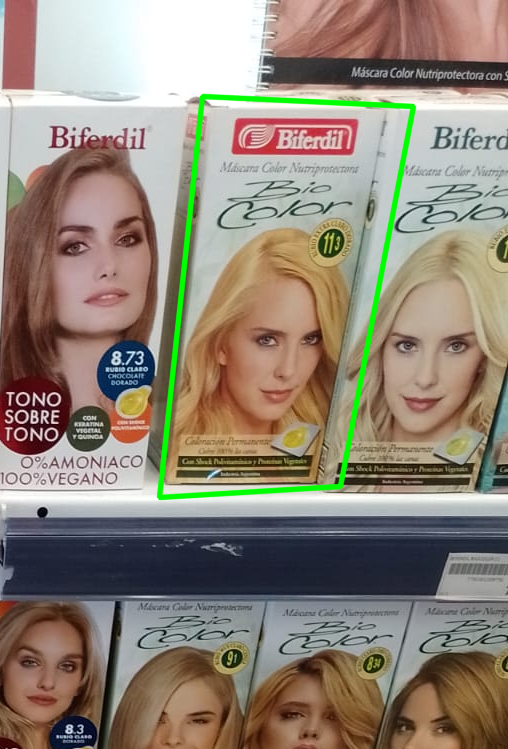

In [46]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Función para recortar la región alrededor del producto con un margen adicional
def crop_expanded_region(gondola, dst, margin_factor=2):
    # Obtener los puntos de la región del producto
    rect = cv2.boundingRect(dst)
    x, y, w, h = rect

    # Calcular el margen adicional
    margin_x = int(w * (margin_factor - 1) / 2)
    margin_y = int(h * (margin_factor - 1) / 2)

    # Ajustar los límites del recorte con el margen
    x1 = max(x - margin_x, 0)
    y1 = max(y - margin_y, 0)
    x2 = min(x + w + margin_x, gondola.shape[1])
    y2 = min(y + h + margin_y, gondola.shape[0])

    # Recortar la región de la imagen de la góndola
    cropped_gondola = gondola[y1:y2, x1:x2]
    return cropped_gondola

# Ajustar el margen de recorte
cropped_gondola_expanded = crop_expanded_region(gondola, dst, margin_factor=2.25)
cv2_imshow(cropped_gondola_expanded)
cv2.waitKey(0)
cv2.destroyAllWindows()


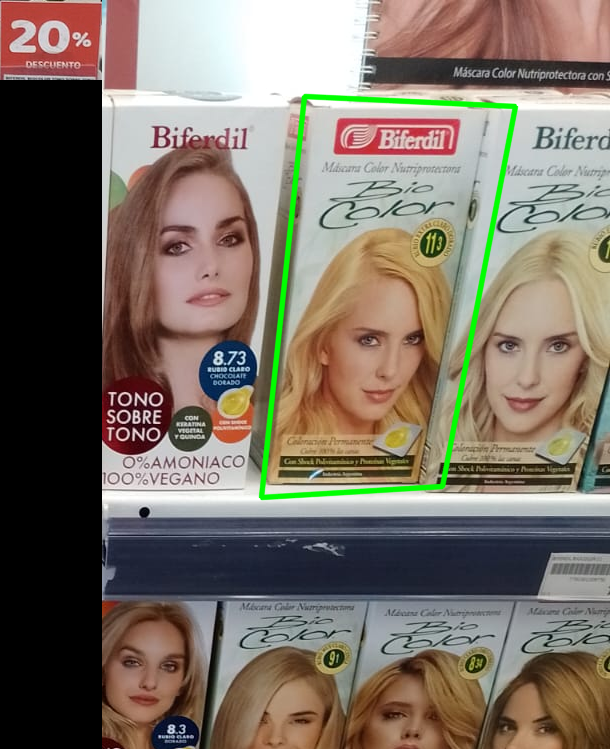

In [47]:
# Cargar la imagen del cartel de promoción
#producto = cv2.imread('/content/drive/MyDrive/9no Cuatrimestre/Proyecto Final/Proyecto Final - Grupo 2/Pruebas Template Matching /descuento_20.png', cv2.IMREAD_COLOR)

cartel = cv2.imread('/content/drive/MyDrive/9no Cuatrimestre/Proyecto Final/Proyecto Final - Grupo 2/Pruebas Template Matching /descuento_20.png', cv2.IMREAD_COLOR)
cartel_gray = cv2.cvtColor(cartel, cv2.COLOR_BGR2GRAY)

# Convertir la región recortada a escala de grises
cropped_gondola_gray = cv2.cvtColor(cropped_gondola_expanded, cv2.COLOR_BGR2GRAY)

# Crear el detector SIFT
sift = cv2.SIFT_create()

# Detectar keypoints y descriptores para el cartel
kp_cartel, des_cartel = sift.detectAndCompute(cartel_gray, None)

# Detectar keypoints y descriptores para la región recortada
kp_cropped, des_cropped = sift.detectAndCompute(cropped_gondola_gray, None)

# Crear el objeto FLANN
index_params = dict(algorithm=1, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Realizar el matching de descriptores
matches = flann.knnMatch(des_cartel, des_cropped, k=2)

# Aplicar ratio test de David Lowe
good_matches = []
for m, n in matches:
    if m.distance < 0.6 * n.distance:
        good_matches.append(m)

# Si se encuentran suficientes "good matches", intentar localizar el cartel
if len(good_matches) > 10:
    src_pts = np.float32([kp_cartel[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp_cropped[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # Estimar homografía
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    matches_mask = mask.ravel().tolist()

    # Obtener dimensiones del cartel
    h, w = cartel_gray.shape

    # Definir puntos del cartel
    pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)

    # Transformar puntos según la homografía encontrada
    dst = cv2.perspectiveTransform(pts, M)

    # Dibujar líneas alrededor del cartel detectado
    cropped_gondola_expanded = cv2.polylines(cropped_gondola_expanded, [np.int32(dst)], True, (0, 255, 0), 3, cv2.LINE_AA)

# Dibujar y mostrar las coincidencias
matches_mask = [1] * len(good_matches)
resultado_cartel = cv2.drawMatches(cartel, kp_cartel, cropped_gondola_expanded, kp_cropped, good_matches, None, matchesMask=matches_mask, flags=2)

cv2_imshow(resultado_cartel)
cv2.waitKey(0)
cv2.destroyAllWindows()
